# New York Times API

Compared to NewsAPI, the NYTAPI is considerably more frustrating to use. The query keywords are extremely sensitive and the queried articles need excessive checking that they are indeed on topic. I used the [Article Search API](https://developer.nytimes.com/docs/articlesearch-product/1/overview) to get URLs for topical articles before getting the full-text articles via [newspaper API's](https://newspaper.readthedocs.io/en/latest/) full-text functionality. There are open-source Python packages for using NYTAPI, but they do not work properly. As a result, I made GET requests directly to the NYTAPI using the Lucene syntax for query filtering (instead of using an open-source package). One may need to contact NYT at code@nytimes.com to increase their [daily request limit](https://developer.nytimes.com/faq#a11) (4000 requests/day).

The code here consists of:
1. Querying metadata (e.g., URLs) of articles, storing them in CSVs
2. Cleaning article URLs:
    1. Using other metadata (e.g., document types, word count)
    2. By assessing the relevance of articles via headlines, keywords, and newsdesk

## Querying Metadata

In [4]:
import sqlite3
import requests
import re
from sqlalchemy import create_engine
from IPython import display

import cnfg
from pprint import pprint
import time
import datetime

import pandas as pd
%pylab inline
import seaborn as sns
sns.set()

In [5]:
# meta (with exception handling for null results)
def web_url(article):
    try:
        return article['web_url']
    except: return

def document_type(article):
    try:
        return article['document_type']
    except: return

def type_of_material(article):
    try:
        return article['type_of_material']
    except: return

def news_desk(article):
    try:
        return article['news_desk']
    except: return

def headline(article):
    try:
        return article['headline']['main']
    except: return

def pub_date(article):
    try:
        return article['pub_date']
    except: return


def source(article):
    try:
        return article['source']
    except: return


def word_count(article):
    try:
        return article['word_count']
    except: return

def word_count(article):
    try:
        return article['word_count']
    except: return
    
def keywords(article):
    keys = []
    try:
        for i in article['keywords']:
            keys.append(i['value'])
        return keys
    except: return

In [6]:
key = cnfg.load('/Users/lkchemposer/.nytimes_config')
apikey = '&api-key=' + key['api_key'] # registered per instructions at https://developer.nytimes.com/get-started

search = 'https://api.nytimes.com/svc/search/v2/articlesearch.json?'

# filters
body = 'body:("environment" AND ("pollution" OR "air pollution" OR "water pollution" OR "ocean pollution" OR "land pollution" OR "noise pollution" OR "waste management" OR "water quality" OR "air quality" OR "global warming" OR ("global warming" AND ("polar bears" OR "ice cap melting")) OR (("solar energy" OR "solar power" OR "solar panels") AND "environment") OR "climate change" OR "climate march" OR "recycling" OR ("electric cars" AND "pollution") OR "wind energy" OR "deforestation" OR ("al gore" AND "pollution") OR ("planet earth" OR "mother earth" AND "nature" AND "pollution") OR "epa" OR "greenhouse effect" OR "greenhouse gases" OR ("fossil fuels" AND "pollution") OR ("natural resources" AND "pollution") OR ("sutainability" AND "green") OR "alternative energy" OR "renewable energy" OR "earth day" OR ("carbon dioxide" AND "pollution") OR "carbon footprint" OR "water conservation" OR "energy conservation" OR "conservation" OR "electronic waste" OR "landfill" OR "composting" OR "department of energy" OR "earth science") OR "environmental health" OR "environmental engineer" OR "environmental justice" OR "environmental ethics" OR "environmental racism" OR "environmental sociology" OR "environmental geography" OR ("environmental education" OR "environmental studies" OR "environmental science" AND ("pollution" OR "nature")))'
fq = 'fq=news_desk.contains:("Environment" "Energy") OR subject.contains:("Environment" "Pollution" "Climate" "Energy") OR ' + body 
end = '&end_date=20111119'
sort = '&sort=newest'

In [9]:
queries = search + fq + '&page=1' + end + sort + apikey
articles = requests.get(queries).json()

In [10]:
# number of total queried articles
articles['response']['meta']['hits']

97993

In [98]:
# check headlines for topic relevance
for i in articles['response']['docs']:
    print(i['headline']['main'])

Politics and Clean Air
Panel Hears Defense of Loan to Solyndra
Solyndra Has a Cousin in the Poorhouse
Highlighting Influence of Asia Behind Artwork
Hip Cities That Think About How They Work
The Fracturing of Pennsylvania
A Phone App for Switching Out Your Light Bulbs
A Phone App for Switching Out Your Light Bulbs
Energy Secretary to Defend Solyndra Loan to Congress
An Assault on the Amazon


### Relevance of Articles

Because there is no limit on the number of results and the articles are sorted in order of newest to oldest, the queried articles on page 200 are not likely to be on topic despite being recent. The NYTAPI has a sort option for relevance, but it did not seem to query good topical results. I resolved this issue by:
1. Setting a limit to the number of results: 200 maximum pages (10 article/page), and
2. Using the last result's previous date as the new "end date" for the next queries

By limiting the number of results, I ended up with (mostly) topical articles dating back to the 80s. In retrospect, 200 pages seem too many still.

In [17]:
newsl = []
errs = []
end = '&end_date=19801105' # arbitrary, used as anchor point in case of error
while True:
    for i in range(1, 201): # up to 200 pages, arbitrarily
        p = '&page={}'.format(i)
        queries = search + fq + p + end + sort + apikey
        time.sleep(1)
        articles = requests.get(queries).json()
        try:
            n = articles['response']['docs']
            for article in n:
                wu = web_url(article)
                dt = document_type(article)
                tm = type_of_material(article)
                nd = news_desk(article)
                hl = headline(article)
                pdt = pub_date(article)
                sc = source(article)
                wc = word_count(article)
                kw = keywords(article)
                news = dict(zip(['web_url', 'document_type', 'type_of_material', 'news_desk',
                                 'headline', 'pub_date', 'source', 'word_count', 'keywords'],
                                [wu, dt, tm, nd, hl, pdt, sc, wc, kw]))
                newsl.append(news)

                # store results every 20 pages
                if i % 20 == 0:
                    display.clear_output() # display progress
                    print(i, hl, wu)
                    newsdf = pd.DataFrame(newsl)
                    newsdf.to_csv('nytimes_env.csv', mode='a', index=False, header=None)
                    newsdf = pd.DataFrame()
                    newsl = [] # reset variable
                    time.sleep(3)
                    
        except Exception as err:
            print(i, err) # log errors
            continue

    nyt = pd.read_csv('nytimes_env.csv', header=None)
    nyt.drop_duplicates(inplace=True)
    
    # previous date of the last article as the new end date
    prevdate = (pd.to_datetime(nyt[4][-1:]) - datetime.timedelta(1)).dt.strftime('%Y%m%d').values[0]
    end = '&end_date={}'.format(prevdate)

140 Letters to the Editor; Latin America: A Different Revolution https://query.nytimes.com/gst/abstract.html?res=9A0DEEDF123DE73ABC4851DFB366838F669EDE


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/Users/lkchemposer/anaconda3/lib/python3.6/site-packages/urllib3/connectionpool.py", line 379, in _make_request
    httplib_response = conn.getresponse(buffering=True)
TypeError: getresponse() got an unexpected keyword argument 'buffering'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/lkchemposer/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-17-0d6942fc71b8>", line 9, in <module>
    articles = requests.get(queries).json()
  File "/Users/lkchemposer/anaconda3/lib/python3.6/site-packages/requests/api.py", line 72, in get
    return request('get', url, params=params, **kwargs)
  File "/Users/lkchemposer/anaconda3/lib/python3.6/site-packages/requests/api.py", line 58, in request
    return session.request(method=method, url=url, **kwargs)
  File "/U

TypeError: must be str, not list

## Cleaning URLs

### Filtering URLs Using Metadata

Because I am only interested in full-text articles to explore topics within environmental news, I need to remove some content types which do not have full-text, are not news articles, or do not reach a minimum (arbitrary) word count (50 words).

In [427]:
nyt = pd.read_csv('nytimes_env.csv', names=sorted(['web_url', 'document_type', 'type_of_material', 'news_desk', 'headline', 'pub_date', 'source', 'word_count', 'keywords']))
nyt.drop_duplicates('web_url', inplace=True)

#drop videos (no text)
nyt.drop(nyt[nyt['type_of_material'] == 'Video'].index, inplace=True)

#drop paid death notice (not useful)
nyt.drop(nyt[nyt['type_of_material'] == 'Paid Death Notice'].index, inplace=True)

#drop schedules (not related content)
nyt.drop(nyt[nyt['type_of_material'] == 'Schedule'].index, inplace=True)

#drop slideshow (not enough text)
nyt.drop(nyt[nyt['type_of_material'] == 'Slideshow'].index, inplace=True)

#drop op-ed, caption (no text)
nyt.drop(nyt[nyt['type_of_material'] == 'Op-Ed; Caption'].index, inplace=True)

#drop anything with below 50 words
nyt.drop(nyt[nyt['word_count'] < 50].index, inplace=True)

### Filtering by Weight of Keywords

Using keywords (tags by NYT), we can use their frequency (among all articles) as a proxy for topical relevance (i.e., if many articles are tagged with the same keywords, they likely talk about the same topic, and presumably, about some environment-related topic). We can also arbitrary assign a "score" if we know what we look for: common environment-related words (e.g., climate, energy, pollution). Here, I assign a "relevance score" to an article by:
1. Adding its keyword frequency
2. Adding 20000 (super high score) if its headline contains specific keywords
3. Adding 20000 if the newsdesk it is assigned to contains specific keywords

We can visualize the distribution of the "relevance score" and decide the threshold for pruning our results (explained below). Note that this _ad hoc_ method have nothing to do with the texts in the article, but about pre-assigned keywords by the NYT in addition to my personal preference.

In [428]:
# turn keywords frequency into weights
nyt['keywords'] = nyt['keywords'].str.lower().str.strip('[]').str.replace('\'', '').str.split(', ')

keys = nyt['keywords'].apply(pd.Series)
key_counts = keys.stack().value_counts()
d = dict(key_counts)

In [459]:
def assign_relevance(row):
    key = 0
    hlkey = 0
    ndkey = 0
    
    for keyword in row['keywords']:
        if keyword in d:
            key += d[keyword]
    
    try:
        hl = row['headline'].lower().replace('[^a-z ]', '').split()
        for word in hl:
            if word in d:
                hlkey += d[keyword]
            if word in ['climate', 'energy', 'pollution']:
                key += 20000
    except:
        hlkey = 0
    
    try:
        nd = row['news_desk'].lower().replace('[^a-z ]', '').split()
        for word in nd:
            if word in ['science', 'environment', 'climate', 'energy']:
                ndkey += 20000
    except:
        nd = 0
    
    return key + hlkey + ndkey

In [460]:
nyt['relevance'] = nyt.apply(assign_relevance, axis=1)

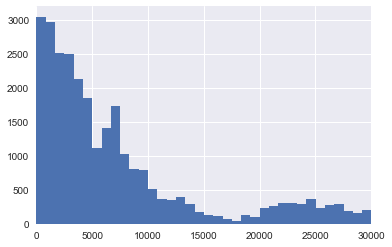

In [478]:
nyt['relevance'].hist(bins=100);
plt.xlim(0, 30000);

Because I chose a super score of 20000, articles in the range of 0-20000 are ones that did not meet both requirements of the headlines and news desk. Around 5000, there seems to be a good separation point. Also, as I wanted to include the articles in the peak with the score of ~7000, I decided to drop articles below the score of 5000.

In [479]:
nyt.drop(nyt[(nyt['relevance'] < 5000)].index, inplace=True)